In [1]:
import cv2
import numpy as np
from pathlib import Path
from IPython.display import display
from PIL import Image

In [2]:
def display_resized(pic, resize=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((w // resize, h // resize), Image.LANCZOS))    

In [3]:
def scale_image(img, w, h):
    interp = cv2.INTER_LANCZOS4
    return cv2.resize(img, (w, h), interpolation=interp)

In [4]:
def poly_area_signed(pts):
    x, y = pts[:, 0], pts[:, 1]
    return 0.5 * np.sum(x * np.roll(y, -1) - y * np.roll(x, -1))

In [5]:
def order_ccw(pts):
    c = pts.mean(axis=0)
    angles = np.arctan2(pts[:, 1] - c[1], pts[:, 0] - c[0])
    pts = pts[np.argsort(angles)]
    tl_idx = np.argmin(pts.sum(axis=1))
    return np.roll(pts, -tl_idx, axis=0).astype(np.float32)

In [6]:
def warp_image(img, quad):
    quad = order_ccw(quad)

    wA = np.linalg.norm(quad[1] - quad[0])
    wB = np.linalg.norm(quad[2] - quad[3])
    hA = np.linalg.norm(quad[3] - quad[0])
    hB = np.linalg.norm(quad[2] - quad[1])

    width  = int(round(max(wA, wB)))
    height = int(round(max(hA, hB)))

    dst = np.array([[0, 0],
                    [width - 1, 0],
                    [width - 1, height - 1],
                    [0, height - 1]], np.float32)

    if poly_area_signed(quad) * poly_area_signed(dst) < 0:
        dst = dst[::-1]

    H = cv2.getPerspectiveTransform(quad, dst)
    warped = cv2.warpPerspective(img, H, (width, height),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)


    if warped.shape[0] > warped.shape[1]:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)

    return warped

In [7]:
def sharpen_image(img):
    kernel = np.array([[ -1.0, -1.0, -1.0],
                       [ -1.0,  9.0, -1.0],
                       [ -1.0, -1.0, -1.0]], dtype=np.float32)

    sharpened = cv2.filter2D(img, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)
    return sharpened

In [8]:
def get_quads(cntrs, img_area):
    quads      = []
    all_polys  = []

    for c in cntrs:
        eps  = 0.015 * cv2.arcLength(c, True)
        poly = cv2.approxPolyDP(c, eps, True)

        all_polys.append(poly)
            
        if 4 < len(poly) <= 8:
            hull = cv2.convexHull(poly)
            peri_h = cv2.arcLength(hull, True)
            poly_h = cv2.approxPolyDP(hull, 0.04 * peri_h, True)
            if len(poly_h) != 4:
                continue
            else:
                poly = poly_h

        if len(poly) != 4 or not cv2.isContourConvex(poly):
            continue
        
        quad = poly.reshape(4, 2).astype(np.float32)
        w_top = np.linalg.norm(quad[1] - quad[0])
        w_bot = np.linalg.norm(quad[2] - quad[3])
        h_left = np.linalg.norm(quad[0] - quad[3])
        h_right= np.linalg.norm(quad[2] - quad[1])
        shortest = min(h_left, h_right, w_top, w_bot)
        longest  = max(h_left, h_right, w_top, w_bot)
        if longest / shortest > ASPECT_HIGH:
            continue
        width = max(w_top, w_bot)
        height = max(h_left, h_right)
        aspect = width / height if height else 0

        if not (ASPECT_LOW <= aspect <= ASPECT_HIGH):
            continue
    
        if cv2.contourArea(quad) < MIN_AREA_RATIO * img_area:
            continue
        
        if cv2.contourArea(c) / cv2.contourArea(quad) < RECT_FILL_RATIO:
            continue

        quads.append(quad)

    final_quads = []
    mpa = np.mean([abs(poly_area_signed(quad)) for quad in quads])
    for quad in quads:
        if abs(poly_area_signed(quad)) < mpa * 2:
            final_quads.append(quad)
 
    return final_quads, all_polys

In [9]:
def binarize_image(img, limit=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if limit is None:
        limit = np.mean(gray) * 0.9
    gray[gray < limit] = 0
    gray[gray >= limit] = 255
    blurred  = cv2.medianBlur(gray, ksize=11)
    _, binarized = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    return binarized

In [10]:
def process_references(ref_dir):
    
    sift = cv2.SIFT_create()
    ref_data = []

    for file in ref_dir.rglob("*"):
        if not file.is_file():
            continue
        
        img = cv2.imread(str(file))

        if img is None:
            print(f"Error: could not read image {file}")
            continue

        padded = cv2.copyMakeBorder(img, PAD, PAD, PAD, PAD, cv2.BORDER_CONSTANT, value=0)
        blurred = cv2.GaussianBlur(padded, (11, 11), 0)

        edges = cv2.Canny(blurred, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h, w = img.shape[:2]
        img_area = h * w
        quads, _ = get_quads(contours, img_area)

        for quad in quads:
            warped = warp_image(padded, quad)
            scaled = scale_image(warped, RESIZE_WIDTH * 4, RESIZE_HEIGHT * 4)
            sharpened = sharpen_image(scaled)
            binarized = binarize_image(sharpened) #it was scaled
            scaled = scale_image(binarized, RESIZE_WIDTH, RESIZE_HEIGHT)

            #display_resized(scaled)

            kp, des = sift.detectAndCompute(scaled, None)
            kp_img = cv2.drawKeypoints(
                scaled,
                kp,
                None,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
            #display_resized(kp_img)

            ref_data.append((file, kp, des))
            #print(f"{file.name:>25s}: {len(kp):4d} key-points")
    return ref_data

In [11]:
def process_references_save(ref_dir):
    
    sift = cv2.SIFT_create()
    ref_data = []

    for file in ref_dir.rglob("*"):
        if not file.is_file():
            continue
        
        img = cv2.imread(str(file))

        if img is None:
            print(f"Error: could not read image {file}")
            continue

        padded = cv2.copyMakeBorder(img, PAD, PAD, PAD, PAD, cv2.BORDER_CONSTANT, value=0)
        blurred = cv2.GaussianBlur(padded, (11, 11), 0)

        edges = cv2.Canny(blurred, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h, w = img.shape[:2]
        img_area = h * w
        quads, _ = get_quads(contours, img_area)

        for quad in quads:
            warped = warp_image(padded, quad)
            cv2.imwrite(str(file.with_suffix('.warped.png')), warped)        

In [12]:
def process_image(padded, quads, ref_data):
    per_card_data = []
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    for quad in quads:
        warped = warp_image(padded, quad)
        scaled = scale_image(warped, RESIZE_WIDTH * 4, RESIZE_HEIGHT * 4)
        sharpened = sharpen_image(scaled)
        binarized = binarize_image(sharpened)
        scaled = scale_image(binarized, RESIZE_WIDTH, RESIZE_HEIGHT)

        display_resized(scaled)

        kp, des = sift.detectAndCompute(scaled, None)
        per_card_data.append((kp, des))
        print(f"{len(kp):4d} key-points")

        best_ref, best_score = None, 0

        for ref_path, kp_ref, des_ref in ref_data:
            knn = bf.knnMatch(des, des_ref, k=2)
            good = [m for m, n in knn if m.distance < DIST_RATIO * n.distance]
            if len(good) > best_score:
                best_ref, best_score = ref_path, len(good)
        
        if best_ref is None:
            print(f"no reasonable match")
        else:
            print(f"best match → {best_ref.name}  ({best_score} good matches)")

In [13]:
def display_annotated_image(img, quads):
    annotated = img.copy()

    for quad in quads:
        cv2.polylines(
            annotated,
            [quad.astype(np.int32)],
            isClosed=True,
            color=(0, 255, 0),
            thickness=2,
            lineType=cv2.LINE_AA
        )

    display_resized(annotated, 3)

In [14]:
TEST_IMG_NAME = "pics/9.jpeg"
REF_IMGS_DIR = "references3"
PAD = 10
MIN_AREA_RATIO = 0.01
ASPECT_LOW, ASPECT_HIGH = 0.333, 3.0
RECT_FILL_RATIO = 0.0001
DIST_RATIO = 0.75
RESIZE_WIDTH = 400
RESIZE_HEIGHT = 300

In [15]:
ref_dir  = Path(REF_IMGS_DIR)
ref_data = process_references(ref_dir)

/home/tothi/python/fkfm/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tothi/python/fkfm/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
#process_references_save(ref_dir)

In [17]:
img_to_process = cv2.imread(TEST_IMG_NAME)

In [18]:
padded = cv2.copyMakeBorder(img_to_process, PAD, PAD, PAD, PAD, cv2.BORDER_CONSTANT, value=0)

In [19]:
blurred = cv2.GaussianBlur(padded, (11, 11), 0)

In [20]:
edges = cv2.Canny(blurred, 100, 200)

In [21]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [22]:
h, w = img_to_process.shape[:2]
img_area = h * w

In [23]:
quads, all_polys = get_quads(contours, img_area)

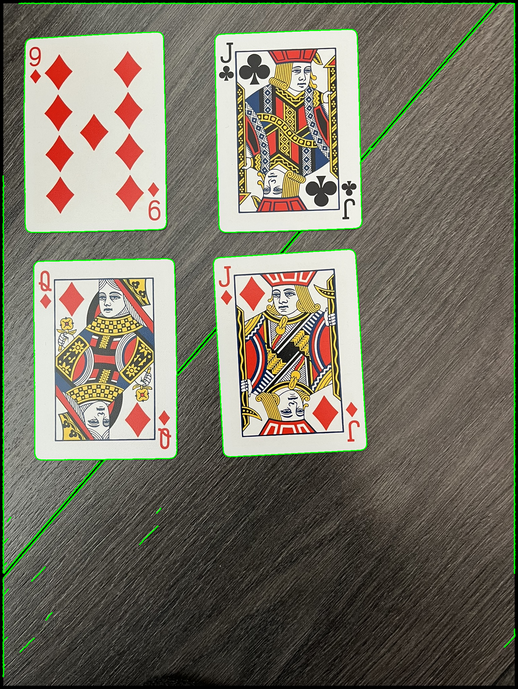

In [24]:
display_annotated_image(padded, contours)

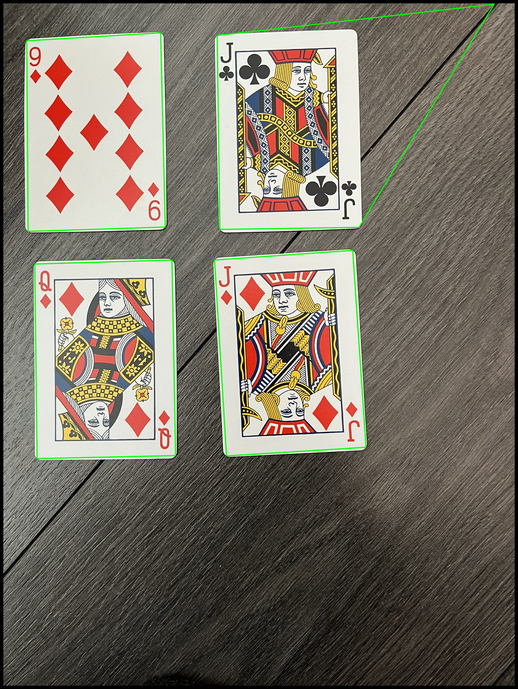

In [25]:
display_annotated_image(padded, quads)

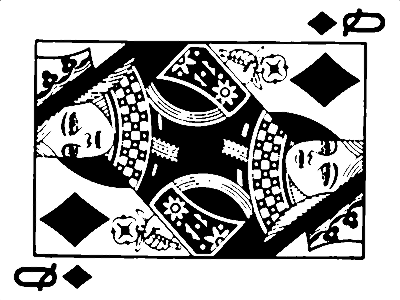

1408 key-points
best match → káró_Q.warped.png  (537 good matches)


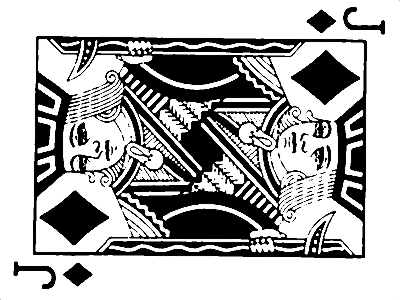

1239 key-points
best match → káró_J.warped.png  (481 good matches)


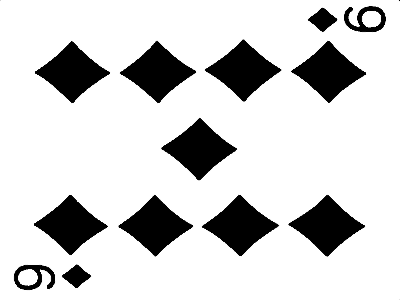

 250 key-points
best match → káró_9.warped.png  (128 good matches)


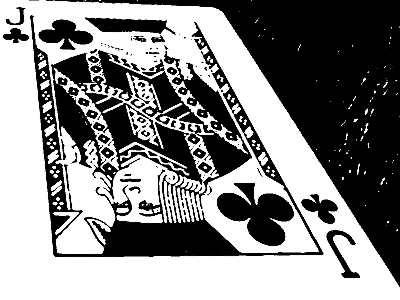

1133 key-points
best match → treff_J.warped.png  (120 good matches)


In [26]:
process_image(padded, quads, ref_data)